In [4]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install catboost
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

## Loading data

In [5]:
# raw data 로딩 
raw_data = pd.read_csv(r'C:\\Users\\user\\Desktop\\intern.csv')
raw_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
0,0,202201095519105,2022-01-11 00:00:00,2022-01-09 12:26:10,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,충청북도 증평군 증평읍 송산로 11 (지평더웰아파트),6900,569.00,6331
1,1,202201105522898,2022-01-11 00:00:00,2022-01-10 10:35:49,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,서울특별시 강남구 논현로85길 52 (역삼동),6900,177.00,6723
2,2,202201115527172,2022-01-12 00:00:00,2022-01-11 11:38:32,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"서울특별시 송파구 올림픽로4길 42 (잠실동, 우성아파트)",6900,221.00,6679
3,3,202201105523467,2022-01-12 00:00:00,2022-01-10 13:21:51,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,강원도 속초시 도리원길 11-14 (노학동),6900,128.00,6772
4,4,202201105522519,2022-01-11 00:00:00,2022-01-10 08:16:21,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"경기도 용인시 수지구 동천로 64 (동천동, 동천마을동문굿모닝힐5차아파트)",6900,157.00,6743


In [186]:
w = pd.read_excel(r'C:\Users\user\Desktop\w.xlsx')
w = w[w['spot'] == '경기도']
w = w.sort_values('date')
w.rename(columns= {'date':'H_YMD'}, inplace=True)
w = w[(w['H_YMD'] > '2020-01-01')]

In [188]:
w.drop(['Unnamed: 0', 'spot'], axis=1, inplace=True)

In [190]:
w.to_csv('C:\\Users\\user\\Desktop\\weather.csv', encoding='utf-8-sig')

In [191]:
# weather data 로딩 
w_data = pd.read_csv(r'C:\Users\user\Desktop\weather.csv')

w_data.rename(columns= {'date':'H_YMD'}, inplace=True)
w_data['H_YMD'] = pd.to_datetime(w_data['H_YMD'])
w_data.head()

,Unnamed: 0,H_YMD,temp,rain,humid
0,9386,2020-01-02,1.30,0.00,83.30
1,9387,2020-01-03,-0.10,0.00,80.50
2,9388,2020-01-04,1.30,0.00,76.10
3,9389,2020-01-05,0.10,0.00,72.40
4,9390,2020-01-06,3.50,3.90,80.80


In [169]:
# 불필요한 컬럼들 제거
# Unnamed: 단순 데이터 순서를 나타내는 컬럼이기에 삭제
# O_YMD: 주문 시간은 오더 건수와 큰 상관이 없기에 삭제
# ORD_NO: 주문 내용의 일련번호이기에 삭제
# PKG_GOODS_NO: PKG_GOODS_NM과 내용이 겹치고 잘못 적재된 데이터이기에 삭제
# RECVR_ROAD_BASE_ADDR: 비대면으로 주문하는 시대에 지역정보는 큰 의미가 없을 것 같아 삭제
# 등등 미래에 예측할 수 없는 데이터는 모두 삭제

# 카피 데이터 생성
copy_data = raw_data[['H_YMD', 'O_YMD', 'GOODS_NO', 'ORD_QTY', 'SALE_PRICE','REAL_ORD_QTY']]
#copy_data = raw_data[['H_YMD', 'O_YMD', 'ORD_QTY', 'GOODS_NO', 'CANCEL_QTY', 'RET_QTY', 'SALE_PRICE', 
#                      'DISCOUNT_AMT', 'FINAL_{RICE', 'REAL_ORD_QTY']]

# 희망배송일 순서대로 데이터를 정렬
copy_data = copy_data.sort_values(by = 'H_YMD')

### 파이프라인

In [7]:
def ADD_DATETIME(df):
    # 희망배송일의 연도,월,일 데이터를 각각 year, month, day 변수에 넣어준다.

    df['H_YMD'] = pd.to_datetime(df['H_YMD'])
    df['year'] = df['H_YMD'].dt.year
    df['month'] = df['H_YMD'].dt.month
    df['day'] = df['H_YMD'].dt.day

    return df

In [8]:
def SHIFT(df):
    df['ord_qty_day']  = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['ORD_QTY'].shift(6)
    df['sale_price_shift']  = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['SALE_PRICE'].shift(6)

    return df

In [9]:
def FE(df):
    # 판매가격 구성단위 변수 생성
    # 판매가격을 최종 주문건수르 나눈 item_price_unit 변수를 생성한다.
    df['item_price_unit'] = df['sale_price_shift'] // df['ord_qty_day']
    df['item_price_unit'].fillna(0, inplace=True)

    # 각 제품의 최솟값과 최댓값을 변수로 넣어준다.(가격별 상승, 하강 추이를 파악하기 위해)
    gp_item_price = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'], as_index=False).agg({'sale_price_shift':[np.min, np.max]})
    gp_item_price.columns = ['O_YMD', 'GOODS_NO', 'hist_min_item_price', 'hist_max_item_price']
    df = pd.merge(df, gp_item_price, on=['O_YMD','GOODS_NO'], how='left')

    # 판매액에서 최솟값을 빼 상승값으로 넣어주고
    # 판매액에서 최댓값을 빼 하강값으로 넣어준다.
    df['price_increase'] = df['sale_price_shift'] - df['hist_min_item_price']
    df['price_decrease'] = df['hist_max_item_price'] - df['sale_price_shift']

    return df

In [26]:
def ROLLING(df):
    # 몇개의 데이터를 가지고 연산을 할 것인가
    # 데이터들을 순차적으로 7일 (window=7)씩 선택해서 mean처럼 이동평균을 냄
    # 3일치의 min,max,std도 고려할 수 있습니다. 

    # Min value
    f_min = lambda x: x.rolling(window=7, min_periods=1).min()
    # Max value
    f_max = lambda x: x.rolling(window=7, min_periods=1).max()
    # Mean value
    f_mean = lambda x: x.rolling(window=7, min_periods=1).mean()
    # Standard deviation
    f_std = lambda x: x.rolling(window=7, min_periods=1).std()

    function_list = [f_min, f_max, f_mean, f_std]
    function_name = ['min', 'max', 'mean', 'std']

    for i in range(len(function_list)):
        df[('ORD_QTY_shifted_%s' % function_name[i])] = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['ord_qty_day'].apply(function_list[i])
    
    # Fill the empty std features with 0
    df['ORD_QTY_shifted_std'].fillna(0, inplace=True)
    
    return df

In [27]:
def LAG(df):
    # 시점을 1일, 2일, 3일로 미뤄서 lag 변수를 생성해준다.

    lag_list = [6,13,20]

    for lag in lag_list:
        ft_name = ('ORD_QTY_shifted%s' % lag)
        #train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['GOODS_NO'])['REAL_ORD_QTY'].shift(lag)
        df[ft_name] = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['ord_qty_day'].shift(lag)
        # Fill the empty shifted features with 0
        df[ft_name].fillna(0, inplace=True)

    return df

In [28]:
def TREND(df):
    # lag 시켰을 때 나온 item_count 판매량을 lag로 나눠서 1을 더해준다.
    lag_list = [6,13,20]
    df['item_trend'] = df['ord_qty_day']

    for lag in lag_list:
        ft_name = ('ORD_QTY_shifted%s' % lag)
        df['item_trend'] -= df[ft_name]

    df['item_trend'] /= len(lag_list) + 1

    return df

In [29]:
def MEAN_DATA(df):
    # 학습데이터의 상품번호 별 일별 판매량 평균
    gp_goods_mean = df.groupby(['O_YMD','GOODS_NO']).agg({'ord_qty_day': ['mean']})
    gp_goods_mean.columns = ['GOODS_mean']
    gp_goods_mean.reset_index(inplace=True)


    # 핛습데이터의 연도별 일별 판매량 평균
    gp_year_mean = df.groupby(['year']).agg({'ord_qty_day': ['mean']})
    gp_year_mean.columns = ['year_mean']
    gp_year_mean.reset_index(inplace=True)

    # 학습데이터의 월별 일별 판매량 평균
    gp_month_mean = df.groupby(['month']).agg({'ord_qty_day': ['mean']})
    gp_month_mean.columns = ['month_mean']
    gp_month_mean.reset_index(inplace=True)

    # 훈련 데이터에 판매량 평균 데이터들 결함
    df = pd.merge(df, gp_goods_mean, on=['O_YMD','GOODS_NO'], how='left')
    df = pd.merge(df, gp_year_mean, on=['year'], how='left')
    df = pd.merge(df, gp_month_mean, on=['month'], how='left')

    return df


In [14]:
# 결측치들을 상품번호별 중앙값으로 대체한다.

def REPLACE_MISSING_VALUE(df):
    # Replace missing values with the median of each shop.            
    for goods_no in df['GOODS_NO'].unique():
        for column in df.columns:
            goods_median = df[(df['GOODS_NO'] == goods_no)][column].median()
            df.loc[(df[column].isnull()) & (df['GOODS_NO'] == goods_no), column] = goods_median

    # Fill remaining missing values on test set with mean.
    df.fillna(df.mean(), inplace=True)
    
    return df 

In [15]:
def DBC_PIPELINE(df):
    temp = df.copy()
   
    temp = ADD_DATETIME(temp)

    temp = SHIFT(temp)

    temp = FE(temp)
    
    temp = ROLLING(temp)

    temp = LAG(temp)

    temp = TREND(temp)

    temp = MEAN_DATA(temp)

    temp = REPLACE_MISSING_VALUE(temp)

    return temp

### 데이터 분할

In [280]:
my_data= copy_data.copy()

my_data

,H_YMD,O_YMD,GOODS_NO,ORD_QTY,SALE_PRICE,REAL_ORD_QTY
166288,2020-01-01 00:00:00,2019-12-30 21:59:40,14375,1,8600,1
37753,2020-01-01 00:00:00,2019-12-30 20:50:07,1901012353,2,6300,2
162585,2020-01-01 00:00:00,2019-12-30 11:02:39,1823,1,3300,1
164041,2020-01-01 00:00:00,2019-12-30 15:19:58,1712010310,1,6900,1
164040,2020-01-01 00:00:00,2019-12-30 10:08:58,1712010310,1,6900,1
...,...,...,...,...,...,...
236658,2022-05-31 00:00:00,2022-05-25 03:16:34,1803010879,1,4500,1
241774,2022-05-31 00:00:00,2022-05-30 15:48:24,1909013359,1,9900,1
236656,2022-05-31 00:00:00,2022-05-29 15:45:30,1803010879,1,4500,1
241810,2022-05-31 00:00:00,2022-05-30 15:54:40,1909013359,1,9900,1


In [281]:
# 데이터를 H_YMD(희망배송일), GOODS_NO(상품 번호)로 groupby를 해준다.
# SALE_PRICE(판매가격), ORD_QTY(주문 건수), REAL_ORD_QTY(최종주문건수)의 평균값과 매매거래량 변수를 만든다.


my_data['O_YMD'] = pd.to_datetime(my_data['O_YMD'])
my_data['O_YMD'] = my_data['O_YMD'].dt.weekday

my_data = my_data.groupby(['H_YMD', 'O_YMD', 'GOODS_NO'], as_index=False)
my_data = my_data.agg({
                        'SALE_PRICE':['sum', 'mean'], 
                        'ORD_QTY':['sum'],
                        'REAL_ORD_QTY':['sum']
                        })

my_data.columns = [
                    'H_YMD', 'O_YMD', 'GOODS_NO',
                    'SALE_PRICE', 'mean_sale_price',
                    'ORD_QTY',
                    'REAL_ORD_QTY',
                    ]
    
# REAL_ORD_QTY 변수는 예측 불가 변수이기 때문에 해당 변수에서 파생된 변수들을 삭제한다
#my_data.drop(['mean_real_ord_qty'], axis=1, inplace=True)


In [282]:
my_data['H_YMD'] = pd.to_datetime(my_data['H_YMD'])
my_data = pd.merge(my_data, w_data, on='H_YMD', how='inner').drop(['Unnamed: 0'], axis=1)
my_data

,H_YMD,O_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,ORD_QTY,REAL_ORD_QTY,temp,rain,humid
0,2020-01-02,0,1823,33000,3300.00,11,11,1.30,0.00,83.30
1,2020-01-02,0,3273,58800,4200.00,15,13,1.30,0.00,83.30
2,2020-01-02,0,4092,24000,4000.00,8,8,1.30,0.00,83.30
3,2020-01-02,0,13957,34300,4900.00,7,7,1.30,0.00,83.30
4,2020-01-02,0,14375,301000,8600.00,41,34,1.30,0.00,83.30
...,...,...,...,...,...,...,...,...,...,...
58999,2022-05-31,6,2010014667,32500,6500.00,5,5,19.50,0.00,54.80
59000,2022-05-31,6,2010014707,144000,9600.00,17,17,19.50,0.00,54.80
59001,2022-05-31,6,2012014895,256500,13500.00,21,21,19.50,0.00,54.80
59002,2022-05-31,6,2103015231,99000,9900.00,10,10,19.50,0.00,54.80


In [283]:
from sklearn.model_selection import train_test_split

my_data['H_YMD'] = pd.to_datetime(my_data['H_YMD'])

test_set =my_data[(my_data['H_YMD'].dt.year == 2022) & (my_data['H_YMD'].dt.month == 5)] # 2022년 5월 데이터를 테스트셋으로 설정

idx =my_data[(my_data['H_YMD'].dt.year == 2022) & (my_data['H_YMD'].dt.month == 5)].index # 2022년 5월 데이터의 인덱스 저장
my_data.drop(idx, inplace=True)

target = 'REAL_ORD_QTY'

Y = my_data[target]
X = my_data.drop(target, axis=1)

X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=.2, shuffle=False, random_state=2022 )
y_test = test_set[target]
X_test = test_set.drop(target, axis=1)

### 파이프라인 가동

In [284]:
X_train = DBC_PIPELINE(X_train)
X_val = DBC_PIPELINE(X_val)
X_test = DBC_PIPELINE(X_test)


In [221]:
X_train = X_train[X_train['H_YMD'] >= '2020-01-08']
y_train = y_train[len(y_train)-len(X_train):]

In [239]:
len(X_train)

45240

In [272]:
X_train.columns

Index(['H_YMD', 'O_YMD', 'GOODS_NO', 'SALE_PRICE', 'mean_sale_price',
       'ORD_QTY', 'temp', 'rain', 'humid', 'year', 'month', 'day',
       'ord_qty_day', 'sale_price_shift', 'item_price_unit',
       'hist_min_item_price', 'hist_max_item_price', 'price_increase',
       'price_decrease', 'ORD_QTY_shifted_min', 'ORD_QTY_shifted_max',
       'ORD_QTY_shifted_mean', 'ORD_QTY_shifted_std', 'ORD_QTY_shifted6',
       'ORD_QTY_shifted13', 'ORD_QTY_shifted20', 'item_trend', 'GOODS_mean',
       'year_mean', 'month_mean'],
      dtype='object')

In [308]:
# xgb_features = [
#                 'SALE_PRICE', 'mean_sale_price', 
#                 'ORD_QTY_shifted_min', 'ORD_QTY_shifted_max', 'ORD_QTY_shifted_mean',
#                 'ORD_QTY_shifted_std', 'ORD_QTY_shifted6', 'ORD_QTY_shifted13',
#                 'ORD_QTY_shifted20', 'item_trend', 'GOODS_mean'
#                 ]

xgb_features = [
                'SALE_PRICE', 
                # 'ord_qty_day', 'sale_price_shift',
                # 'ORD_QTY_shifted_min', 'ORD_QTY_shifted_max', 'ORD_QTY_shifted_mean',
                # 'ORD_QTY_shifted_std', 'ORD_QTY_shifted6', 'ORD_QTY_shifted13',
                # 'ORD_QTY_shifted20', 'item_trend', 'GOODS_mean'
                ]

xgb_train = X_train[xgb_features]
xgb_val = X_val[xgb_features]
xgb_test = X_test[xgb_features]

In [309]:
xgb_model = XGBRegressor(max_depth=5, 
                         n_estimators=1000, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.1, 
                         seed=0)
xgb_model.fit(xgb_train, 
              y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, y_train), (xgb_val, y_val)], 
              verbose=20, 
              early_stopping_rounds=20)

[0]	validation_0-rmse:22.69181	validation_1-rmse:22.88489
[20]	validation_0-rmse:9.38065	validation_1-rmse:9.95329
[40]	validation_0-rmse:8.98893	validation_1-rmse:9.96647
[44]	validation_0-rmse:8.98221	validation_1-rmse:9.98971


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1000,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [132]:
import joblib

joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

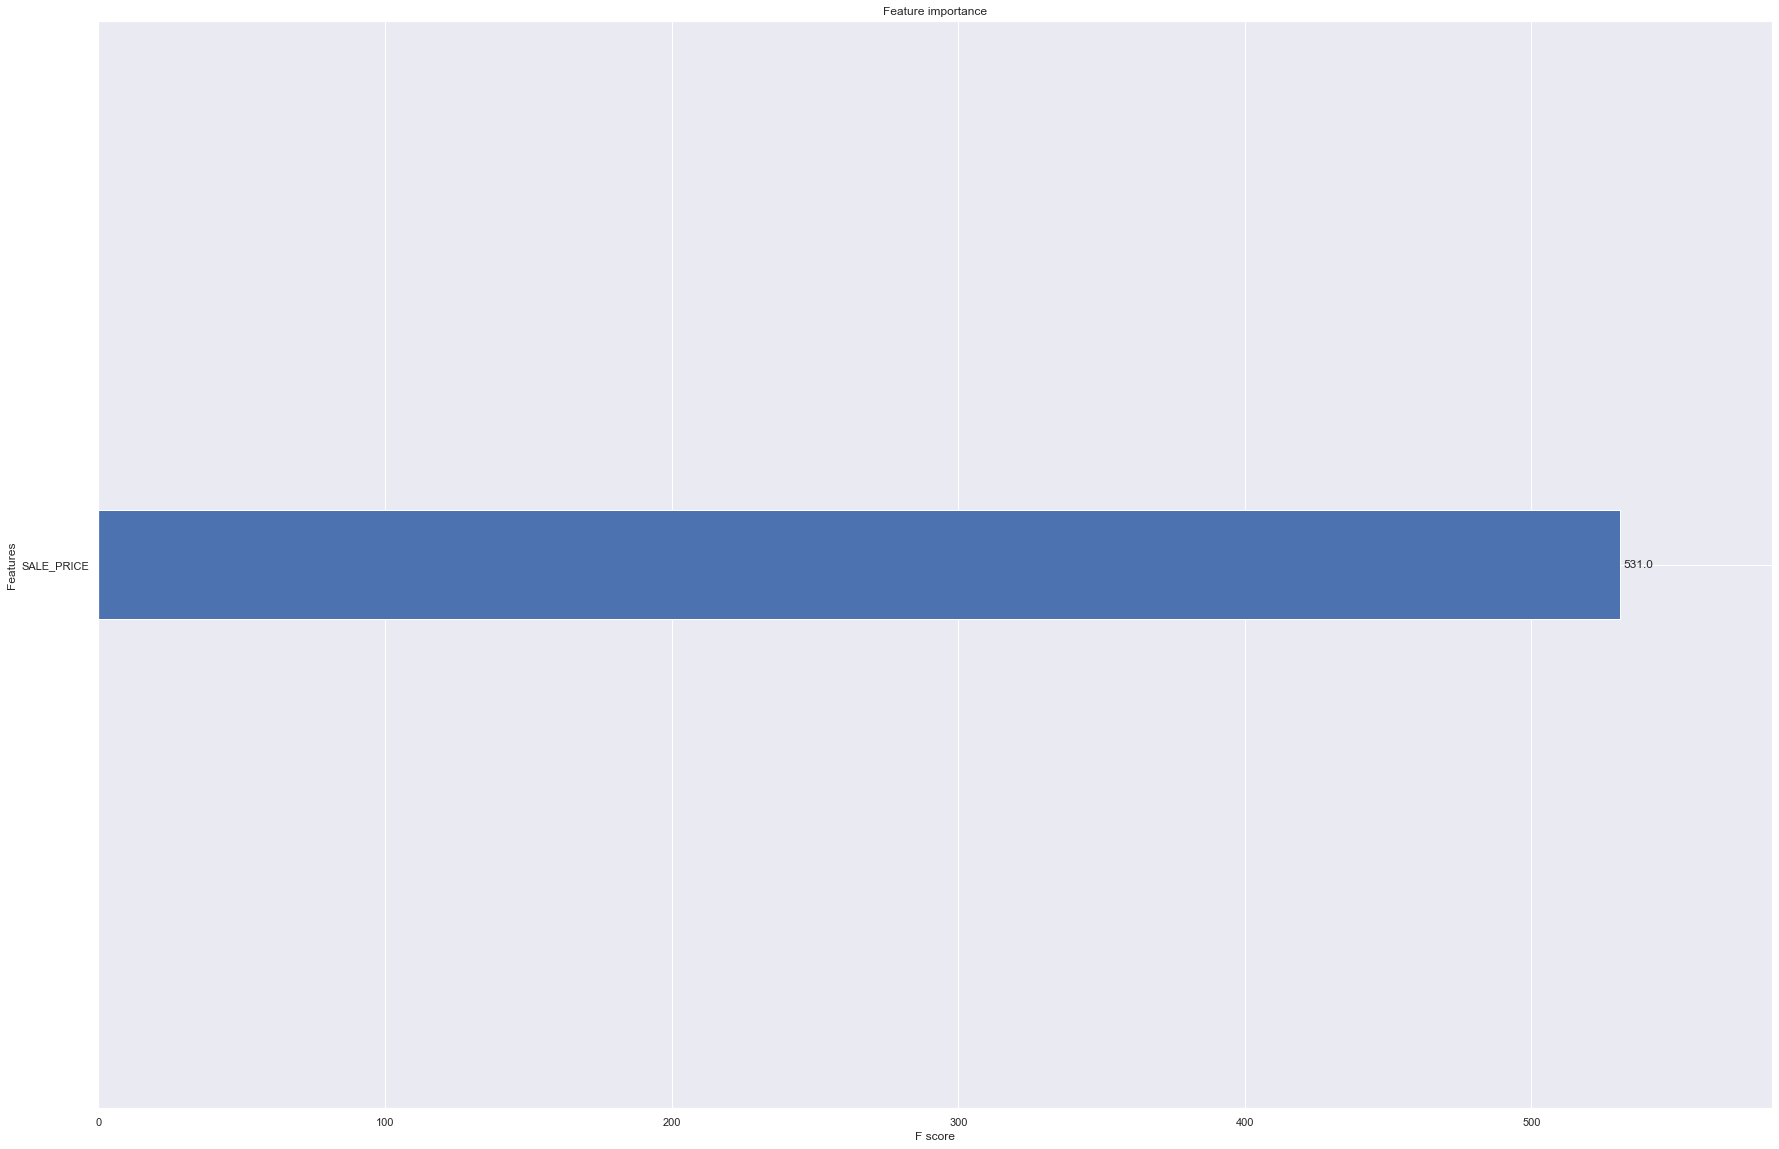

In [310]:
plt.rcParams["figure.figsize"] = (30, 20)
plot_importance(xgb_model)
plt.show()

In [316]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [317]:
from sklearn.metrics import r2_score

print('r2:', r2_score(y_test, xgb_test_pred))
print('Train rmse:', np.sqrt(mean_squared_error(y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, xgb_val_pred)))

r2: 0.8328885361521927
Train rmse: 9.124716306173012
Validation rmse: 9.88695972544207


In [313]:
# 자재코드와 자재명을 딕셔너리 형태로 만들기
GOODS_DIC = {1712010310 : '두메산나물비빔밥재료', 14375:	'옛날잡채(500g)', 3273:'채소계란찜(340g)', 13957:'셀프두부조림(600g)', 1901012353:'수제계란말이(350g)',
             13529:'메밀소바(2인분)', 1803010879:'고소한도토리묵무침(360g)', 2012014895:'한돈 제육볶음(700g)', 2204016772:'소고기유니짜장소스(1인분, 200g)', 
             1823:'숙주나물(300g)', 4092:'건표고버섯볶음', 14985:'양장피', 1808011751:'꼬막무침 (260g)', 1903012675:'순살코다리강정(180g)', 
             2010014667:'우삼겹숙주볶음(250g)', 1806011271:'열무비빔밥재료믹스(2인분)', 2103015231:'[심방골주부X더반찬] 시골 돼지짜글이(600g)', 
             2010014707:'고구마 품은 라자냐(450g)', 1805011121:'고사리나물볶음(150g)', 1909013359:'가정집 오징어불고기/셀프(380g)'
             }

In [314]:
def to_csv(predict, x_test, y_test):
    predict = pd.DataFrame(predict)
    predict['H_YMD'] = x_test['H_YMD'][-(len(x_test)):]
    predict['GOODS_NO'] = x_test['GOODS_NO']
    
    y_test = pd.DataFrame(y_test)
    y_test.reset_index(drop=True, inplace=True)
    y_test['H_YMD'] = x_test['H_YMD'][-(len(x_test)):]
    y_test['GOODS_NO'] = x_test['GOODS_NO']
    
    for n in GOODS_DIC.keys():
        predict['GOODS_NO'].loc[predict['GOODS_NO'] == n ] = GOODS_DIC[n]
        y_test['GOODS_NO'].loc[y_test['GOODS_NO'] == n ] = GOODS_DIC[n]

    
    predict.columns = ['REAL_ORD_QTY',  'H_YMD', 'GOODS_NM']
    y_test.columns = ['REAL_ORD_QTY',  'H_YMD', 'GOODS_NM']

    predict = predict.groupby(['H_YMD', 'GOODS_NM'])
    predict = predict.sum()

    y_test = y_test.groupby(['H_YMD','GOODS_NM'])
    y_test = y_test.sum()

    return predict, y_test

In [297]:
xgb_result, y_result = to_csv(xgb_test_pred, X_test, y_test)

y_result.to_csv('C:\\Users\\user\\Desktop\\y_result.csv', encoding='utf-8-sig')
xgb_result.to_csv('C:\\Users\\user\\Desktop\\xgb_result.csv', encoding='utf-8-sig')


In [318]:
xgb_result[0:20]

REAL_ORD_QTY
H_YMD      GOODS_NM                                
2022-05-02 [심방골주부X더반찬] 시골 돼지짜글이(600g)         35.93
           가정집 오징어불고기/셀프(380g)                43.64
           건표고버섯볶음                            46.45
           고구마 품은 라자냐(450g)                   10.23
           고사리나물볶음(150g)                      23.14
           고소한도토리묵무침(360g)                    44.77
           꼬막무침 (260g)                        60.35
           두메산나물비빔밥재료                        189.10
           셀프두부조림(600g)                       69.37
           소고기유니짜장소스(1인분, 200g)               47.68
           수제계란말이(350g)                       54.54
           숙주나물(300g)                         48.84
           순살코다리강정(180g)                      54.70
           양장피                                88.40
           옛날잡채(500g)                        133.56
           우삼겹숙주볶음(250g)                      16.99
           채소계란찜(340g)                        70.80
           한돈 제육볶음(700g)                      79.05
2022-05-03 [심방골주부X더반찬] 시골 돼지짜글이(600g)         36.93
           가정집 오징어불고기/셀프(380g)                38.00

In [45]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [299]:
X_train = X_train[xgb_features]
X_val = X_val[xgb_features]

In [300]:
def evaluate_regr(y, pred):
    mse = mean_squared_error(y, pred)
    rmse_val = np.sqrt(mse)
    mae_val = mean_absolute_error(y, pred)
    r2 = r2_score(y, pred)
    print('RMSE : {} | MAE : {} | r2 : {} '.format(round(rmse_val,5),round(mae_val,5),round(r2,5)))

# 여러 모델의 성능 확인 함수 
def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    print('###', model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
#--------------------------------------------------------------------
#모델별로 평가 확인 

ridge_reg = Ridge(alpha=0)      # best alpha = 0
lasso_reg = Lasso(alpha=1)        # best alpha = 1
tree_reg = DecisionTreeRegressor(random_state=13)
forest_reg = RandomForestRegressor(n_estimators=100,random_state=13)

for model in [ridge_reg, lasso_reg,tree_reg,forest_reg]:
# for model in [forest_reg]:
    get_model_predict(model, X_train, X_val, y_train, y_val)

### Ridge ###
RMSE : 6.69351 | MAE : 3.8725 | r2 : 0.90082 
### Lasso ###
RMSE : 6.68613 | MAE : 3.85298 | r2 : 0.90103 
### DecisionTreeRegressor ###
RMSE : 7.49715 | MAE : 3.81555 | r2 : 0.87557 
### RandomForestRegressor ###
RMSE : 5.90491 | MAE : 2.93544 | r2 : 0.92281 


In [232]:
pd.DataFrame([X_train.columns, ridge_reg.coef_]).T

,0,1
0,ord_qty_day,0.33
1,sale_price_shift,-0.00
2,item_price_unit,-0.00
3,price_increase,0.00
4,price_decrease,0.00
5,temp,-0.01
6,rain,-0.01
7,humid,-0.00
8,ORD_QTY_shifted_min,0.03
9,ORD_QTY_shifted_max,-0.05
